In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from imblearn.over_sampling import SMOTE 


In [2]:
def verify_status(val):    
    if 'Trip Verified' in val:
        return True
    elif 'Not Verified' in val:
        return False
    else:
        return np.nan

In [3]:
def scrape_reviews(max_pages, link, df_columns, rating_columns):
    stats = []
    comments = []
    title = []
    bio = []
    for i in range(1, max_pages):
        source_code = requests.get(f"{link}/page/{i}/").text
        soup = BeautifulSoup(source_code, "html.parser")
        stats.extend(soup.find_all('div', class_ = 'review-stats'))
        comments.extend([i.text.strip() for i in soup.find_all('div', class_ = 'text_content')])
        title.extend([i.text.strip() for i in soup.find_all('h2', class_= 'text_header')])
        bio.extend([i.text.strip() for i in soup.find_all('h3', class_= 'text_sub_header userStatusWrapper')])

    df = pd.DataFrame(columns = df_columns)

    for i in range(len(stats)):    
        data_dict = {}
        for row in stats[i].select('.review-ratings tr'):
            columns = row.find_all('td')
            key = columns[0]['class'][-1]
            value = columns[1].text.strip()
            data_dict[key] = value

        for row in stats[i].select('.review-ratings tr'):
            columns = row.find_all('td')
            aspect = columns[0]['class'][-1]
            star_fill_count = len(columns[1].find_all('span', class_='star fill'))
            if aspect in rating_columns:
                data_dict[aspect] = star_fill_count

        df.loc[len(df)] = data_dict

    df['comments'] = comments
    df['title'] = title
    df['bio'] = bio
    return df

# TODO: Add more preprocessing
def data_preprocessing(df):
    df['bio'] = df['bio'].apply(lambda value : value.replace('\n', ' '))
    names, countries, dates = [], [], []
    pattern = re.compile(r'^(.*?)\s*\((.*?)\)\s*(\d{1,2}\w{0,2}\s+\w+\s+\d{4})$')

    for i in range(len(df)):
        match = pattern.match(df.bio[i])
        if match:
            names.append(match.group(1).strip())
            countries.append(match.group(2).strip())
            dates.append(match.group(3).strip())
        else:
            names.append(0)
            countries.append(0)
            dates.append(0)
        
    df['name'] = names
    df['country'] = countries
    df['date'] = dates
    df['verified'] = df.comments.apply(verify_status)
    df['cleaned_comments'] = df.comments.apply(lambda x: x.split('|')[-1].strip())
    return df

def scrape_ratings(link):
    source_code = requests.get(link).text
    soup = BeautifulSoup(source_code, "html.parser")

    airlines = []
    ratings = []
    reviews = []

    for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':    
        try:
            data = soup.find_all(id = f'a2z-ldr-{char}')[0].text.strip().split('    ')[1:]
            data = [i.split() for i in data]
            for i in data:
                airlines.append(' '.join(i[:-2]))
                ratings.append(i[-2])
                reviews.append(i[-1])
        except:
            continue
    df = pd.DataFrame({'Airline': airlines, 'Rating': ratings, 'Reviews': reviews})
    return df

## Scraping all review sites

In [4]:
lounge_reviews_df = scrape_reviews(max_pages = 43, 
                                   link = "https://www.airlinequality.com/lounge-reviews/british-airways",
                                   df_columns = ['lounge_name', 'airport', 'type_of_lounge', 'date_visit', 'type_of_traveller', 'comfort', 
                                                 'cleanliness', 'bar_and_beverages', 'catering', 'washrooms', 'wifi_connectivity', 
                                                 'staff_service','recommended'],
                                   rating_columns = ['comfort', 'cleanliness', 'bar_and_beverages', 'catering', 'washrooms', 
                                                    'wifi_connectivity', 'staff_service'])

lounge_reviews_df = data_preprocessing(lounge_reviews_df)

In [5]:
airline_reviews_df = scrape_reviews(max_pages = 372,
                                    link = "https://www.airlinequality.com/airline-reviews/british-airways",
                                    df_columns = ['aircraft', 'type_of_traveller', 'cabin_flown', 'route', 'date_flown', 'seat_comfort', 
                                             'cabin_staff_service', 'food_and_beverages', 'inflight_entertainment', 'ground_service', 
                                             'wifi_and_connectivity', 'value_for_money', 'recommended'],
                                    rating_columns = ['seat_comfort', 'cabin_staff_service', 'food_and_beverages', 'inflight_entertainment', 
                                                      'ground_service', 'wifi_and_connectivity', 'value_for_money'])

airline_reviews_df = data_preprocessing(airline_reviews_df)

In [6]:
seat_reviews_df = scrape_reviews(max_pages = 21,
                                 link = 'https://www.airlinequality.com/seat-reviews/british-airways',
                                 df_columns = ['cabin_flown', 'aircraft_type', 'seat_layout', 'date_flown', 'type_of_traveller', 
                                               'sleep_comfort', 'sitting_comfort', 'seatbed_width', 'seatbed_length', 'privacy_of_seat', 
                                               'seat_power_supply_firstbusiness', 'seat_storage_firstbusiness', 'recommended'],
                                 rating_columns = ['sleep_comfort', 'sitting_comfort', 'seatbed_width', 'seatbed_length', 'privacy_of_seat',
                                                    'seat_power_supply_firstbusiness', 'seat_storage_firstbusiness'])

seat_reviews_df = data_preprocessing(seat_reviews_df)

## Gettings all airline ratings 

In [7]:
url = 'https://skytraxratings.com/a-z-of-airline-ratings/'
source_code = requests.get(url).text
soup = BeautifulSoup(source_code, "html.parser")
airline_names = soup.find_all('td', class_='column-2')
ratings = soup.find_all('td', class_='column-1')

all_airlines_df = pd.DataFrame({'airline_name': [i.text.strip() for i in airline_names], 'rating': [i.text.strip() for i in ratings]})

## Overall comparisons with other companies

In [8]:
lounge_ratings_df = scrape_ratings('https://www.airlinequality.com/review-pages/a-z-lounge-reviews/airline-lounge-review-ratings/')
lounge_ratings_df.Reviews = lounge_ratings_df.Reviews.astype(int)
lounge_ratings_df.Rating = lounge_ratings_df.Rating.astype(int)

In [9]:
airline_ratings_df = scrape_ratings('https://www.airlinequality.com/review-pages/a-z-airline-reviews/airline-review-ratings/')
airline_ratings_df.Reviews = airline_ratings_df.Reviews.astype(int)
airline_ratings_df.Rating = airline_ratings_df.Rating.astype(int)

In [10]:
seat_ratings_df = scrape_ratings('https://www.airlinequality.com/review-pages/a-z-seat-reviews/airline-seat-review-ratings/')
seat_ratings_df.Reviews = seat_ratings_df.Reviews.astype(int)
seat_ratings_df.Rating = seat_ratings_df.Rating.astype(int)

## Performing analysis on overall standing of British Airways

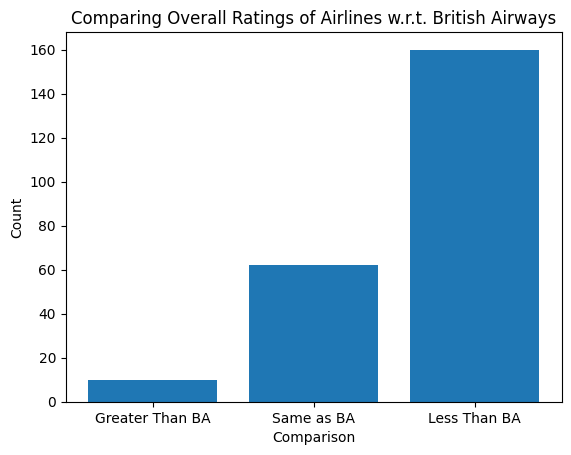

In [11]:
c_value = all_airlines_df.loc[all_airlines_df.airline_name == 'British Airways', 'rating'].values[0]

# Count variables greater and less than the value of c
greater_than = all_airlines_df[all_airlines_df['rating'] > c_value]
equal_to = all_airlines_df[all_airlines_df['rating'] == c_value]
less_than = all_airlines_df[all_airlines_df['rating'] < c_value]

# Plot a bar graph
plt.bar(['Greater Than BA', 'Same as BA', 'Less Than BA'], 
        [len(greater_than), len(equal_to), len(less_than)])
plt.xlabel('Comparison')
plt.ylabel('Count')
plt.title(f'Comparing Overall Ratings of Airlines w.r.t. British Airways')
plt.show()


## Finding the 15 airlines with relatively most reviews

In [12]:
lounge_ratings_df['scaled_reviews'] = lounge_ratings_df.Reviews / lounge_ratings_df.Reviews.max()

In [13]:
airline_ratings_df['scaled_reviews'] = airline_ratings_df.Reviews / airline_ratings_df.Reviews.max()

In [14]:
seat_ratings_df['scaled_reviews'] = seat_ratings_df.Reviews / seat_ratings_df.Reviews.max()

In [15]:
import pandas as pd

merged_df = pd.merge(airline_ratings_df, seat_ratings_df, on='Airline', how='outer', suffixes=('_df1', '_df2'))
merged_df['scaled_reviews_df2'].fillna(0, inplace=True)
merged_df['sum_scaled_reviews'] = merged_df['scaled_reviews_df1'] + merged_df['scaled_reviews_df2']
merged_df = merged_df.drop(['scaled_reviews_df1', 'scaled_reviews_df2'], axis=1)

In [16]:
import pandas as pd

final_df = pd.merge(merged_df, lounge_ratings_df, on='Airline', how='outer', suffixes=('_df3', '_df4'))
final_df['scaled_reviews'].fillna(0, inplace=True)
final_df['sum_scaled_reviews'] = final_df['sum_scaled_reviews'] + final_df['scaled_reviews']

final_df.sort_values(by=['sum_scaled_reviews'], ascending=False, inplace=True)

In [17]:
final_df.head(15)

,Airline,Rating_df1,Reviews_df1,Rating_df2,Reviews_df2,sum_scaled_reviews,Rating,Reviews,scaled_reviews
140,British Airways,5.0,3729.0,4.0,195.0,2.637436,4.0,420.0,1.000000
88,American Airlines,2.0,5850.0,3.0,109.0,1.868498,4.0,130.0,0.309524
516,United Airlines,3.0,4805.0,3.0,100.0,1.857998,4.0,220.0,0.523810
198,Emirates,5.0,2323.0,4.0,137.0,1.613944,5.0,216.0,0.514286
318,Lufthansa,5.0,2395.0,4.0,123.0,1.509219,5.0,197.0,0.469048
395,Qantas Airways,6.0,1867.0,6.0,100.0,1.431966,5.0,252.0,0.600000
397,Qatar Airways,7.0,2340.0,8.0,113.0,1.419963,6.0,185.0,0.440476
156,Cathay Pacific Airways,7.0,1433.0,5.0,142.0,1.273162,7.0,126.0,0.300000
182,Delta Air Lines,4.0,2956.0,4.0,88.0,1.168486,4.0,89.0,0.211905
435,Singapore Airlines,7.0,1525.0,6.0,109.0,1.126801,5.0,129.0,0.307143


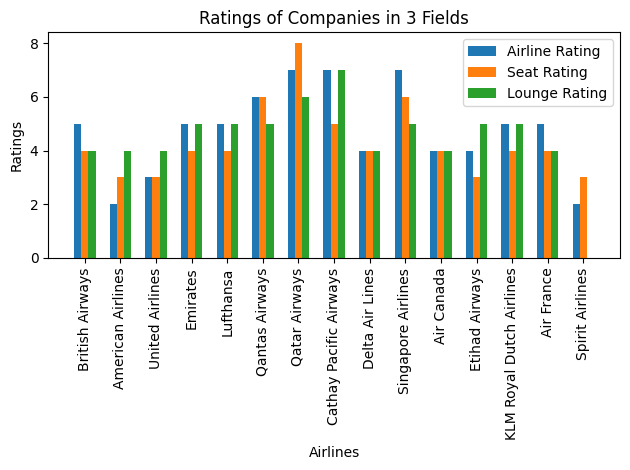

In [18]:
top_15_df = final_df.head(15).fillna(0)

bar_width = 0.2
index = np.arange(len(top_15_df.Airline))

# Plotting
plt.bar(index, top_15_df.Rating_df1, width = bar_width, label = 'Airline Rating')
plt.bar(index + bar_width, top_15_df.Rating_df2, width = bar_width, label = 'Seat Rating')
plt.bar(index + 2 * bar_width, top_15_df.Rating, width = bar_width, label = 'Lounge Rating')

# Customizing the chart
plt.xlabel('Airlines')
plt.ylabel('Ratings')
plt.title('Ratings of Companies in 3 Fields')
plt.xticks(index + bar_width, top_15_df.Airline, rotation = 90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


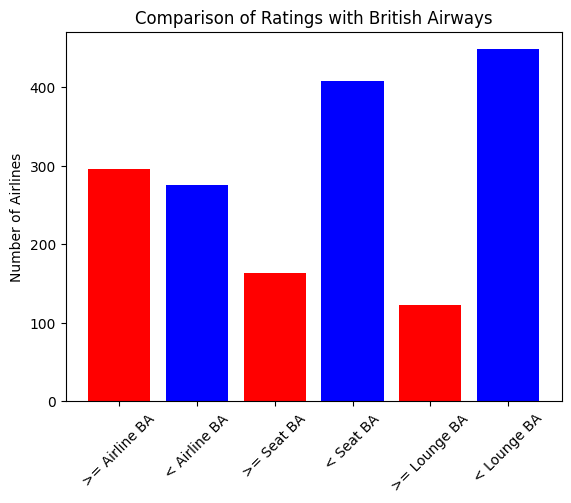

In [19]:
df = final_df.fillna(0)
ba_ratings = df[df['Airline'] == 'British Airways'][['Rating_df1', 'Rating_df2', 'Rating']].squeeze()

better_df1 = df[df['Rating_df1'] >= ba_ratings['Rating_df1']].shape[0]
lesser_df1 = df[df['Rating_df1'] < ba_ratings['Rating_df1']].shape[0]

better_df2 = df[df['Rating_df2'] >= ba_ratings['Rating_df2']].shape[0]
lesser_df2 = df[df['Rating_df2'] < ba_ratings['Rating_df2']].shape[0]

better_overall = df[df['Rating'] >= ba_ratings['Rating']].shape[0]
lesser_overall = df[df['Rating'] < ba_ratings['Rating']].shape[0]

labels = ['>= Airline BA', '< Airline BA', '>= Seat BA', '< Seat BA', '>= Lounge BA', '< Lounge BA']
ratings = [better_df1, lesser_df1, better_df2, lesser_df2, better_overall, lesser_overall]

fig, ax = plt.subplots()
ax.bar(labels, ratings, color=['red', 'blue', 'red', 'blue', 'red', 'blue'])
ax.set_ylabel('Number of Airlines')
ax.set_title('Comparison of Ratings with British Airways')
plt.xticks(rotation=45)
plt.show()


`Based on the above results, we need to improve the overall airline ratings as there are more airlines with a better rating than British Airways. `

In [21]:
import pandas as pd
from textblob import TextBlob

comments = airline_reviews_df.cleaned_comments
sentiment_scores = []
for comment in comments:
    analysis = TextBlob(str(comment))
    sentiment_scores.append(analysis.sentiment.polarity)

df = pd.DataFrame({'comments': comments})
df['sentiment_score'] = sentiment_scores
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative')

In [27]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models

comments = df['comments']
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
tokenized_comments = []

for comment in comments:
    comment_lower = str(comment).lower()
    words = word_tokenize(comment_lower)
    words = [word for word in words if word.isalnum() and word not in stop_words]
    tokenized_comments.append(words)

dictionary = corpora.Dictionary(tokenized_comments)
corpus = [dictionary.doc2bow(words) for words in tokenized_comments]
lda_model = models.LdaModel(corpus, num_topics = 5, id2word=dictionary, passes = 30, random_state = 2)
topics = lda_model.print_topics(num_words = 5)
df['dominant_topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [28]:
topics

[(0,
  '0.020*"good" + 0.019*"first" + 0.018*"crew" + 0.015*"food" + 0.014*"club"'),
 (1,
  '0.012*"ba" + 0.012*"flight" + 0.011*"service" + 0.009*"british" + 0.009*"airways"'),
 (2,
  '0.021*"ba" + 0.017*"flight" + 0.008*"passengers" + 0.007*"class" + 0.006*"lounge"'),
 (3,
  '0.022*"flight" + 0.016*"ba" + 0.012*"seat" + 0.011*"seats" + 0.010*"good"'),
 (4,
  '0.030*"flight" + 0.016*"ba" + 0.010*"british" + 0.010*"airways" + 0.010*"us"')]

In [29]:
manual_topics = {0: 'Staff Service', 1: 'Cabin Crew', 2: 'Seat', 3: 'Inflight Entertainment', 4: 'Lounge'}

In [30]:
df['category'] = df['dominant_topic'].apply(lambda x: manual_topics[x])

<Axes: xlabel='category'>

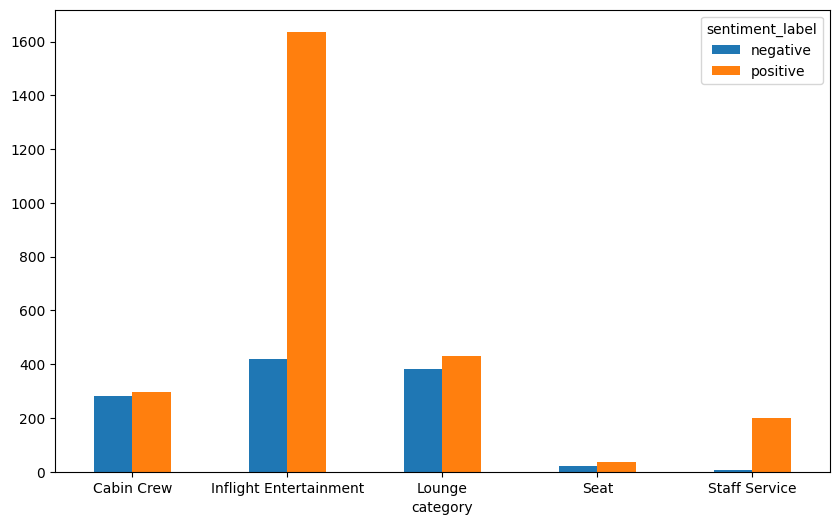

In [31]:
df.groupby(['category', 'sentiment_label']).size().unstack().plot(kind='bar', figsize=(10, 6), rot=0)

<Figure size 1000x600 with 0 Axes>

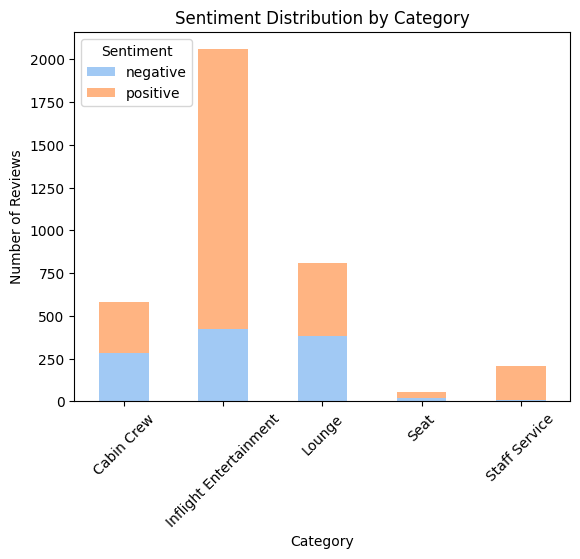

In [32]:
pivot_df = df.pivot_table(index='category', columns='sentiment_label', aggfunc='size', fill_value=0)

# Plot the stacked bar graph
plt.figure(figsize=(10, 6))
sns.set_palette("pastel")
pivot_df.plot(kind = 'bar', stacked = True, rot = 45)
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.legend(title = 'Sentiment', loc='upper left')
plt.show()


In [33]:
comments_column = df['comments']

words_to_remove = ['BA', 'British Airway']

def remove_words(text):
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

df['comments_trimmed'] = comments_column.apply(remove_words)

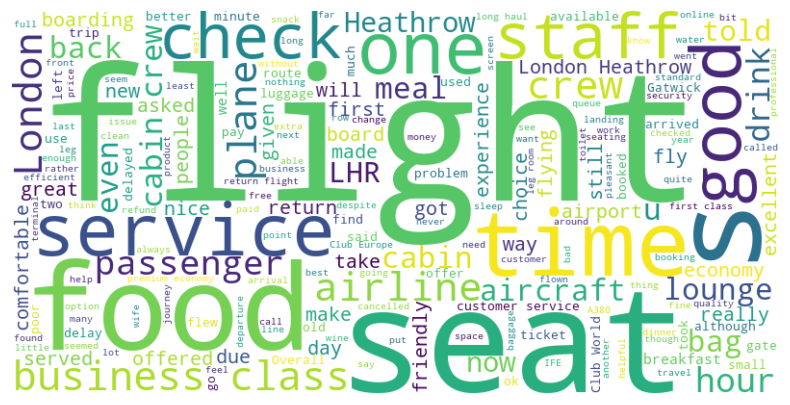

In [34]:
comments = ' '.join(df['comments_trimmed'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud of Comments')
plt.show()


In [35]:
airline_reviews_df['sentiment'] = df['sentiment_label']

In [36]:
def clean_name(name):
    try:
        return name.split()[-1].split('-')[0]
    except:
        return str(name)
airline_reviews_df['new_airline'] = airline_reviews_df.aircraft.apply(clean_name)

In [37]:
airline_reviews_df.dropna(subset=['aircraft']).groupby(['new_airline', 'sentiment']).count().sort_values(by = 'comments', ascending = False).head(15)

,,aircraft,type_of_traveller,cabin_flown,route,date_flown,seat_comfort,cabin_staff_service,food_and_beverages,inflight_entertainment,ground_service,...,value_for_money,recommended,comments,title,bio,name,country,date,verified,cleaned_comments
new_airline,sentiment,,,,,,,,,,,,,,,,,,,,,
777,positive,373,373,373,372,371,372,372,371,345,369,...,373,373,373,373,373,373,373,373,138,373
A320,positive,299,299,299,299,298,294,294,262,56,298,...,299,299,299,299,299,299,299,299,135,299
747,positive,194,194,194,194,192,194,194,194,186,192,...,194,194,194,194,194,194,194,194,60,194
A380,positive,160,160,160,160,160,160,160,155,154,160,...,160,160,160,160,160,160,160,160,69,160
777,negative,125,124,125,125,125,124,124,122,114,125,...,125,125,125,125,125,125,125,125,52,125
787,positive,109,109,109,109,109,108,108,108,106,108,...,109,109,109,109,109,109,109,109,63,109
A320,negative,104,104,104,104,104,102,102,86,33,104,...,104,104,104,104,104,104,104,104,58,104
A319,positive,97,97,97,97,97,96,96,84,16,97,...,97,97,97,97,97,97,97,97,26,97
747,negative,88,88,88,88,88,88,88,87,83,88,...,88,88,88,88,88,88,88,88,28,88


# Model Building area

In [38]:
df = pd.read_csv('customer_booking.csv', encoding='latin-1')

# Sources say you can book flights only 1 year in advance including the return flight
# We'll create a new column adding both the leading day and length of stay and delete everything that is greater than 355 days

df['total_days'] = df.purchase_lead + df.length_of_stay
df = df[df['total_days'] <= 355]

# Round the flight hour to the nearest integer
df.flight_duration = np.round(df.flight_duration)
df.flight_duration = df.flight_duration.astype(str)

remove_cols = ['route', 'booking_origin', 'total_days', 'sales_channel', 'flight_hour']
df.drop(remove_cols, axis = 1, inplace = True)

# df.flight_hour = df.flight_hour.astype(str)
object_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns = object_cols, drop_first = True)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('booking_complete', axis = 1), df.booking_complete)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept = False, class_weight = {0: 0.157, 1: 0.843}, max_iter = 100, random_state = 42)

model.fit(x_train, y_train)

LogisticRegression(class_weight={0: 0.157, 1: 0.843}, fit_intercept=False,
                   random_state=42)

Text(0.5, 1.0, 'Probability impact of different variables')

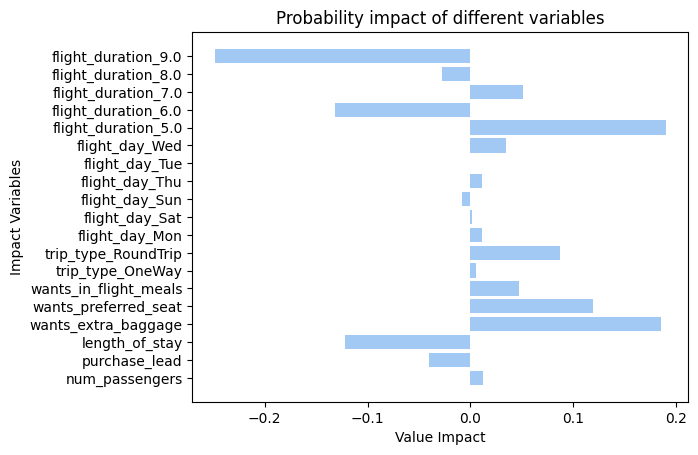

In [41]:
plt.barh(width = list(model.coef_[0]), y = df.drop('booking_complete', axis = 1).columns)
plt.xlabel('Value Impact')
plt.ylabel('Impact Variables')
plt.title('Probability impact of different variables')

In [44]:
predictions = model.predict_proba(x_test)
    
thresh = []
true_true = []
false_false = []
from sklearn.metrics import classification_report
count = 0.45

for i in range(10):
    thresh.append(str(np.round(count, 2)))
    p0_1 = predictions[:, 1] >= count
    results = classification_report(y_test, p0_1, output_dict = True)
    true_true.append(results['1']['recall'])
    false_false.append(results['0']['recall'])
    count += 0.01

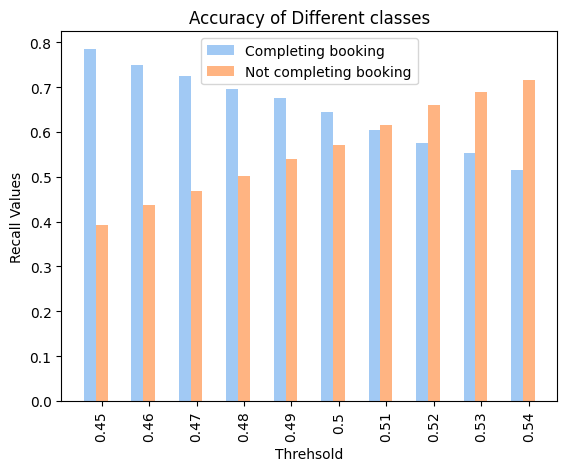

In [45]:
plt.figure()
bar1 = plt.bar(range(10), true_true, width = 0.25)
bar2 = plt.bar([i + 0.25 for i in range(10)], false_false, width = 0.25)
plt.xticks([i + 0.25 for i in range(10)], thresh, rotation = 90)
plt.xlabel("Threhsold") 
plt.ylabel('Recall Values') 
plt.title("Accuracy of Different classes") 
plt.legend( (bar1, bar2), ('Completing booking', 'Not completing booking') ) 
plt.show()